<a href="https://colab.research.google.com/github/baelanche/Deep_learning_introduction/blob/master/1.%EC%86%90%EA%B8%80%EC%94%A8%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B6%84%EB%A5%98/RNN%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC_%EC%86%90%EA%B8%80%EC%94%A8_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN을 이용하여 손글씨 이미지 분류하기

## Preprocessing

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## see mnist dataset

In [50]:
mnist = keras.datasets.mnist
((train_images, train_labels) , (test_images, test_labels)) = mnist.load_data()

In [5]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape
# Parameter (BHW)
# 1 : 데이터의 크기
# 2 : 이미지 height
# 3 : 이미지 width

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## plt를 이용한 이미지 출력

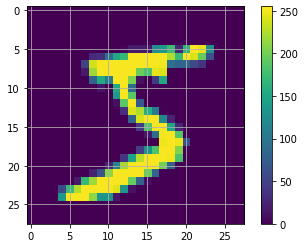

answer : 5


In [6]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar() # 우측의 색상바
plt.grid(True) # 격자
plt.show()
print(f"answer : {train_labels[0]}")

## 0이 아닌 값 출력하기

In [7]:
# train_images[0].reshape(-1) 1차원으로 변경됨
list(filter(lambda x: x != 0, train_images[0].reshape(-1)))[:10]

[3, 18, 18, 18, 126, 136, 175, 26, 166, 255]

## dtype 출력하기

In [8]:
print(train_images.dtype)
print(train_labels.dtype)
print(test_images.dtype)
print(test_labels.dtype)
# unsigned int 8bit

uint8
uint8
uint8
uint8


## 데이터 범위 확인

In [9]:
print(list(filter(lambda x: x != 0, train_images[0].reshape(-1)))[:10])
print(list(filter(lambda x: x != 0, train_labels.reshape(-1)))[:10])
print(list(filter(lambda x: x != 0, test_images[0].reshape(-1)))[:10])
print(list(filter(lambda x: x != 0, test_labels.reshape(-1)))[:10])

[3, 18, 18, 18, 126, 136, 175, 26, 166, 255]
[5, 4, 1, 9, 2, 1, 3, 1, 4, 3]
[84, 185, 159, 151, 60, 36, 222, 254, 254, 254]
[7, 2, 1, 4, 1, 4, 9, 5, 9, 6]


## train/test 이미지 데이터의 최소/최대값을 출력

In [10]:
min(train_images.reshape(-1)), max(train_images.reshape(-1)), min(test_images.reshape(-1)), max(test_images.reshape(-1))

(0, 255, 0, 255)

## 정수형을 실수형으로 변경

In [51]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

## 데이터 0-1 노말라이즈 수행

In [7]:
# 현재 배열의 값 0-255 를 0-1 로 바꾸는 과정
train_images = train_images / 255
test_images = test_images / 255

## 값 확인

In [13]:
print(list(filter(lambda x: x != 0, train_images[0].reshape(-1)))[:10])
print(list(filter(lambda x: x != 0, test_images[0].reshape(-1)))[:10])

[0.011764705882352941, 0.07058823529411765, 0.07058823529411765, 0.07058823529411765, 0.49411764705882355, 0.5333333333333333, 0.6862745098039216, 0.10196078431372549, 0.6509803921568628, 1.0]
[0.32941176470588235, 0.7254901960784313, 0.6235294117647059, 0.592156862745098, 0.23529411764705882, 0.1411764705882353, 0.8705882352941177, 0.996078431372549, 0.996078431372549, 0.996078431372549]


## 5장 shape


In [15]:
train_images[:5].shape

(5, 28, 28)

## 5장을 분류하기

In [25]:
np.hstack(train_images[:5]).shape
# plt.imshow(np.hstack(train_images[:5]))
# plt.show()

(28, 140)

## transpose로 shape 변경하기(GPU방식)



In [29]:
train_images[:5].transpose((1, 0, 2)).reshape(28, -1).shape # 0:B 1:H 2:W

(28, 140)

## plt로 출력하기

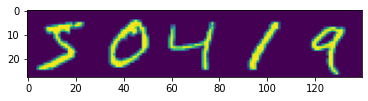

In [30]:
plt.imshow(train_images[:5].transpose((1,0,2)).reshape(28, -1))
plt.show()

## 흑백으로 출력하기

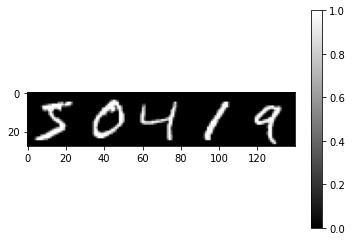

[5 0 4 1 9]


In [33]:
plt.imshow(train_images[:5].transpose((1,0,2)).reshape(28, -1), cmap='gray') # default : heatmap
plt.colorbar()
plt.show()
print(train_labels[:5])

# Data augmentataion - Noise

## np.random.random 으로 난수 만들기

In [8]:
np.random.random() # 0-1

0.5820211206148056

## (28, 28)

In [12]:
np.random.random((28, 28)).shape

(28, 28)

## plt로 확인

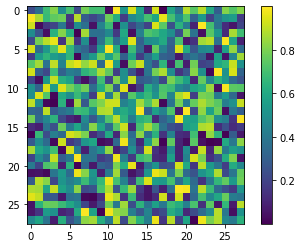

In [14]:
plt.imshow(np.random.random((28, 28)))
plt.colorbar()
plt.show()

## 평균 0, 표준편차 0.1, 사이즈 1

In [16]:
np.random.normal(0.0, 0.1, 1)

array([0.02519057])

## 평균 3.0, 표준편차 0.01, 사이즈 1

In [17]:
np.random.normal(3.0, 0.01, 1)

array([2.99858817])

## 가우시안 노이즈함수로 (28, 28) 을 생성한 뒤 plt로 출력하기

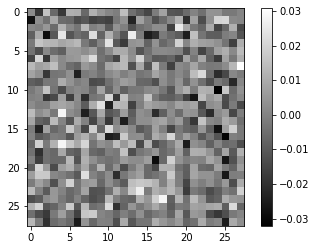

In [21]:
plt.imshow(np.random.normal(0.0, 0.01, (28, 28)), cmap='gray')
plt.colorbar()
plt.show()

## 가우시안 노이즈(28, 28)을 생성하고 각각 tensor를 더한 뒤 변수에 할당하기

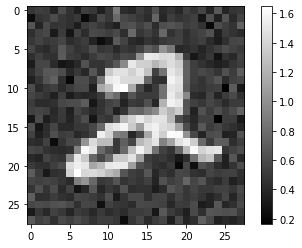

In [32]:
noisy_image = train_images[5] + np.random.normal(0.5, 0.1, (28, 28))
plt.imshow(noisy_image, cmap='gray')
plt.colorbar()
plt.show()

## noisy 이미지 최대값 설정하기

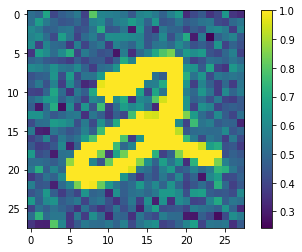

In [31]:
noisy_image[noisy_image > 1.0] = 1.0
# noisy_image
plt.imshow(noisy_image)
plt.colorbar()
plt.show()

## train_noisy_images, test_noisy_images 만들기

In [38]:
train_noisy_images = train_images + np.random.normal(0.5, 0.1, train_images.shape)
train_noisy_images[train_noisy_images > 1.0] = 1.0

test_noisy_images = test_images + np.random.normal(0.5, 0.1, test_images.shape)
test_noisy_images[test_noisy_images > 1.0] = 1.0

## lables에 onehot 인코딩을 적용하여 (배치 사이즈, 클래스 개수)의 shape으로 변경

In [52]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
print(train_labels.shape, test_labels.shape)

(60000, 10) (10000, 10)


### * 구글드라이브에서 파일 불러오기

In [42]:
from google.colab import drive
drive.mount('/content/drive')

# 링크 눌러서 코드 복붙

Mounted at /content/drive
